# Iterative Least-Likely Class Method

Functions used:

`attack_ILLM`

`visualize_attack_ILLM`

`single_attack_stats_ILLM`

`all_samples_attack_ILLM`

`confidence_range_attack_ILLM`

`analyze_attack_ILLM`


These functions are aleady implemented!

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

from modules.fgsm import*
from modules.bim import*
from modules.illm import*

## 0. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 1. Introduction

Values for the hyper parameters given in [1]:

- $\alpha = \frac{1}{255}$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

Number of iterations: 20
			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			shower curtain
Confidence: 		99.99%				1.57%



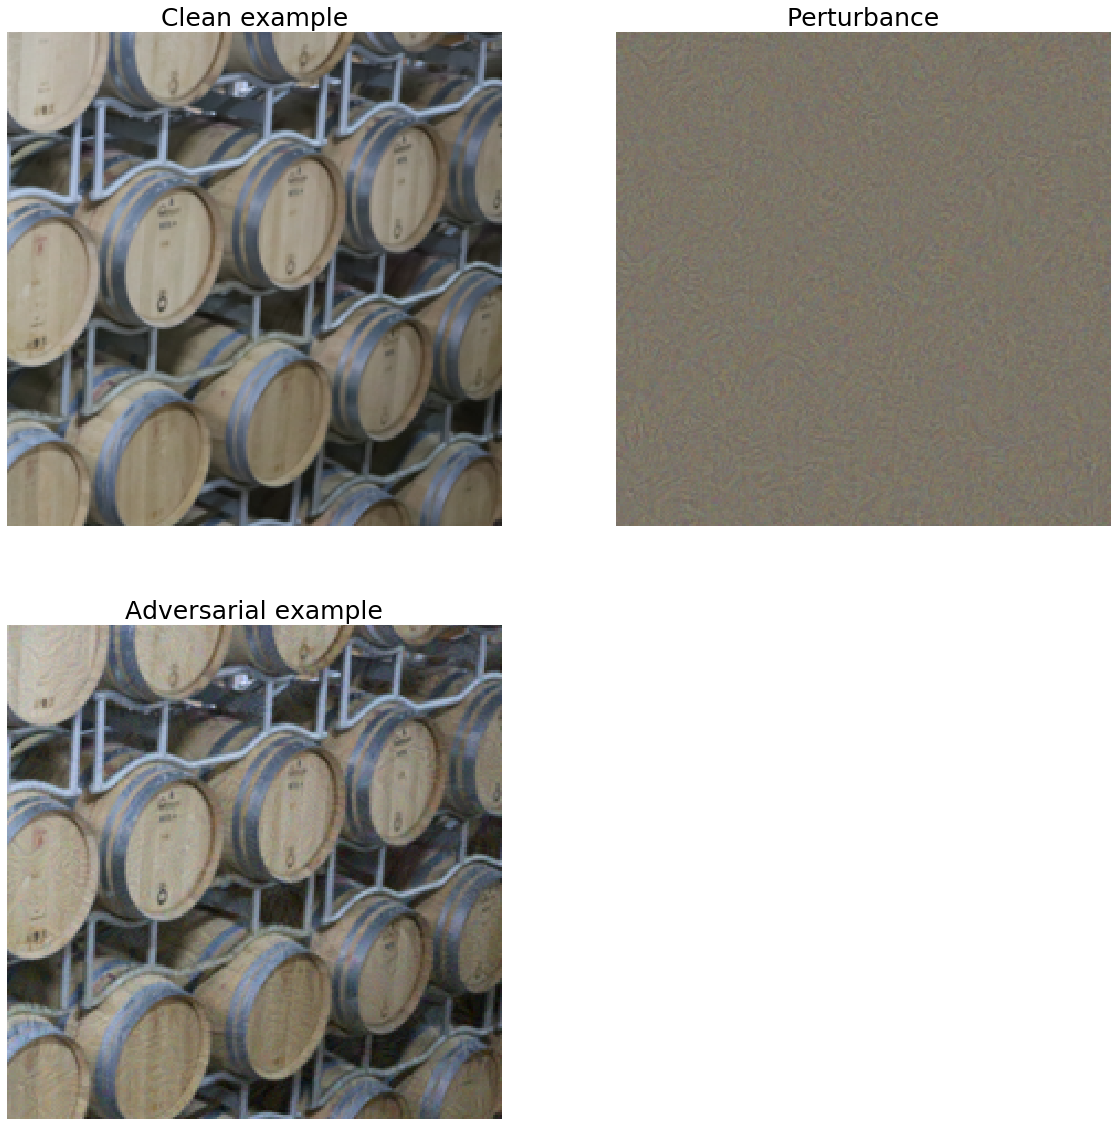

In [13]:
sample = 766
alpha = 1/255
epsilon = 16/255

visualize_attack_ILLM(data_loader, mean, std, model, predict, epsilon, alpha, sample, summarize_attack,folder=None)

Number of iterations: 20
			Clean image	 Adversarial image

Actual class: 		bagel, beigel			bagel, beigel
Predicted class: 	bagel, beigel			mushroom
Confidence: 		44.26%				1.97%



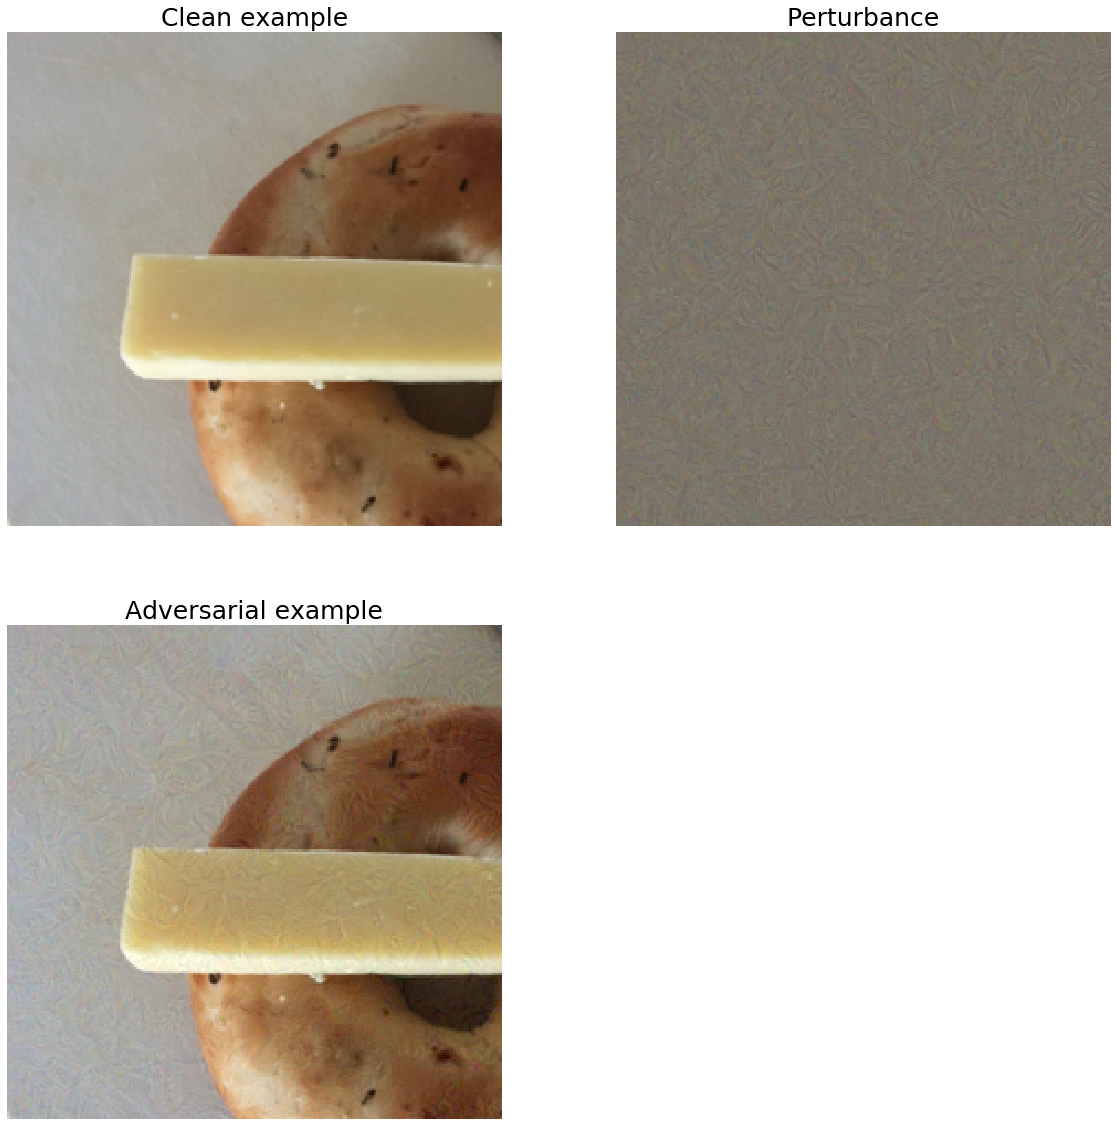

In [5]:
sample = 41

alpha = 1/255
epsilon = 16/255

visualize_attack_ILLM(data_loader, mean, std, model, predict, epsilon, alpha, sample, summarize_attack,folder=None)

## 2. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 2.1 Confidence ranges

In [ ]:
#
max_confidence = 0.60
min_confidence = 0.40

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.90
min_confidence = 0.85

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255] 
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.95
min_confidence = 0.90

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 0.99
min_confidence = 0.95

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

In [ ]:
#
max_confidence = 1.00
min_confidence = 0.99

# Hyperparameter for attacks
epsilons = [0, 0.5/255, 1/255, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]    
alpha = 1/255

result = confidence_range_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, min_confidence, max_confidence)

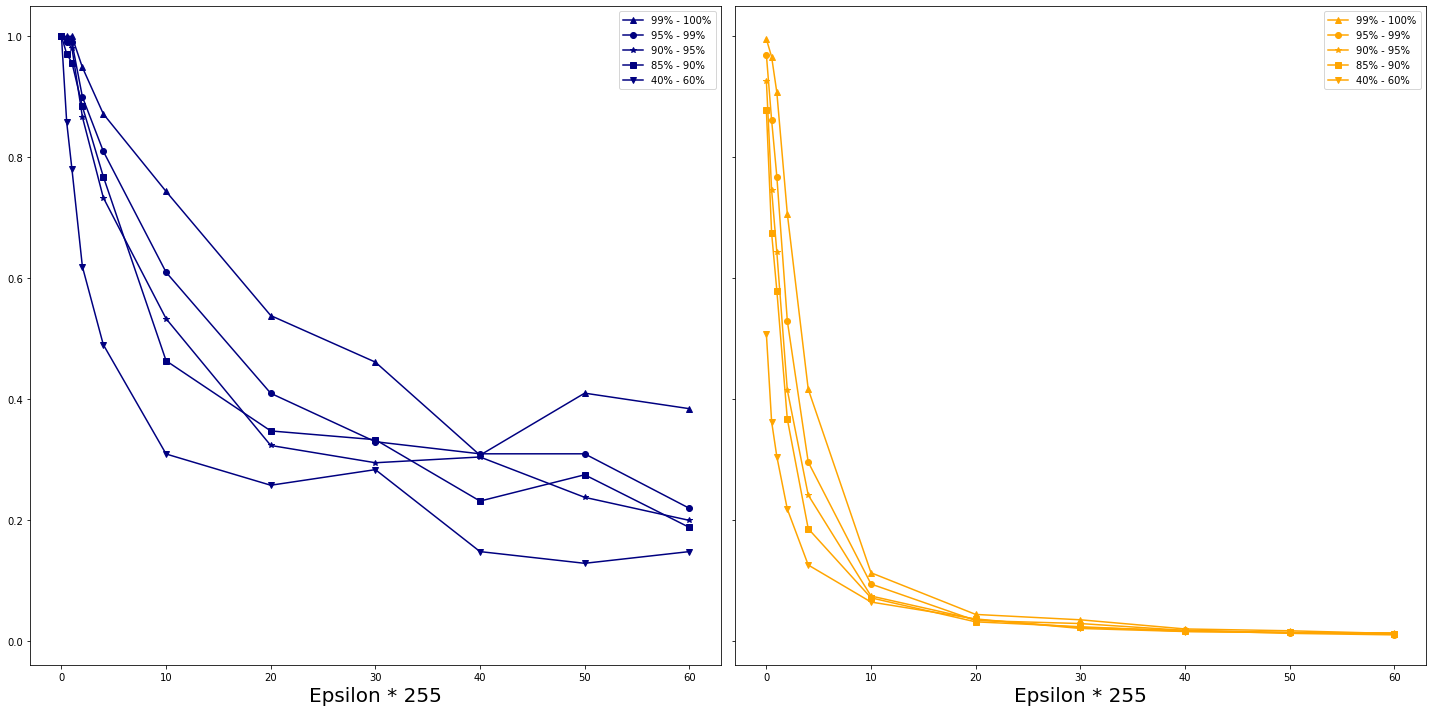

In [21]:
### PLOT 1

# Load data
result_99 = pd.read_csv("results/ILLM/ILLM-Conf99.csv")
result_95 = pd.read_csv("results/ILLM/ILLM-Conf95.csv")
result_90 = pd.read_csv("results/ILLM/ILLM-Conf90.csv")
result_85 = pd.read_csv("results/ILLM/ILLM-Conf85.csv") 
result_40 = pd.read_csv("results/ILLM/ILLM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/ILLM/ILLM-accuracies_confidences.png")

### 2.2 Including false initial predictions

We compute attacks with all examples. Since the computational cost is high compared to FGSM we split it up into different intervals of epsilon.

In [ ]:
# Filename: ILLM-all_samples.csv

epsilons = [8/255, 16/255, 32/255, 48/255, 64/255, 96/255, 128/255]

alpha = 1/255 # recommended in paper
filename_ext = "0-128"

top1, top5, conf = all_samples_attack_ILLM(data_loader, mean, std, model, predict, epsilons, alpha, filename_ext)

In [11]:
fgsm = pd.read_csv("results/FGSM/FGSM-all_samples.csv", index_col=0)
bim = pd.read_csv("results/BIM/BIM-all_samples.csv", index_col=0)
illm = pd.read_csv("results/ILLM/ILLM-all_samples.csv", index_col=0)
illm.head(2)

,Epsilon,Top1,Top5,Confidence
0,0.0,0.844,0.971,0.623875
1,1.0,0.751,0.926,0.426610


In [12]:
acc_clean = []
conf_clean = []

for i in range(len(fgsm)):
    acc_clean.append(0.844)
    conf_clean.append(0.623875)

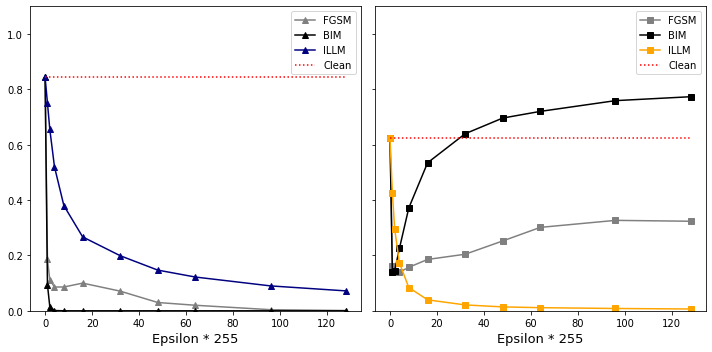

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

## Left: Accuracies
axs[0].plot(fgsm["Epsilon"], fgsm["Top1"], "-^", color='grey', label='FGSM')
axs[0].plot(bim["Epsilon"], bim["Top1"], "-^", color='black', label='BIM')
axs[0].plot(illm["Epsilon"], illm["Top1"], "-^", color='navy', label='ILLM')
axs[0].plot(illm["Epsilon"], acc_clean, ":", color='red', label='Clean')
axs[0].set_ylim(0,1.1)
axs[0].legend()
axs[0].set_xlabel("Epsilon * 255", fontsize=13)

## Right: Confidences
axs[1].plot(fgsm["Epsilon"], fgsm["Confidence"], "-s", color='grey', label='FGSM')
axs[1].plot(bim["Epsilon"], bim["Confidence"], "-s", color='black', label='BIM')
axs[1].plot(illm["Epsilon"], illm["Confidence"], "-s", color='orange', label='ILLM')
axs[1].plot(illm["Epsilon"], conf_clean, ":", color='red', label='Clean')
axs[1].set_ylim(0,1.1)
axs[1].legend()
axs[1].set_xlabel("Epsilon * 255", fontsize=13)

## Save plot
fig.tight_layout()
fig.savefig("plots/ILLM/ILLM-compare_attacks_FGSM_BIM.png")

## 3. Indivdual Images

### 3.1 Confidence and correct/false class over epsilon for individual images

We calculate the adversarial confidences for each case where the initial prediction is successful for different epsilons. This allows us to find examples with e.g. high adversarial confidence for further investigations.

**Note:** 
This calculation can yield different results on different hardware. For more details see the appendix of the report.

In [ ]:
# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255]
alpha = 1/255


result = pd.DataFrame()

# Find examples with correct initial prediction
samples = []

for sample in range(10):
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)
    
    predicted_classes, _, _ = predict(model, image_clean, class_index, return_grad=False)
        
    if predicted_classes[0] == class_index.squeeze().numpy():
        samples.append(sample)
        clear_output(wait=True)
        print("Identified correct clean predictions: {}".format(len(samples)))
       
result["Sample"] = samples

for epsilon in epsilons:   
    conf = []    
    num_iterations = int(np.min([np.ceil( (epsilon/alpha) + 4 ), np.ceil( 1.25 * epsilon/alpha ) ]))
    
    # Attack only if initial prediction is correct
    counter = 1
    for sample in samples:
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print("Processing sample {} of {}".format(counter, len(samples)))
               
        # Attack and evaluate success
        conf_adv, corr_adv, _ = single_attack_stats_ILLM(data_loader, mean, std, model, predict, 
                                                    epsilon, alpha, sample, idx_to_name, num_iterations) 
        
        # If attack yields wrong class, take confidence. If not set confidence to 0.
        if corr_adv == 0:
            conf.append(conf_adv)

        else:
            conf.append(0)
            
        counter += 1
      
    result["Epsilon " + str(int(epsilon*255))] = conf

# Set index and save results
result.set_index("Sample", inplace=True)
print("Done")
#result.to_csv("results/ILLM/ILLM-adversarial_confidences_corr_only.csv")

We find examples with high adversarial confidence, where the targeted class is fairly similar to the original one and an example which should be easy to manipulate.

In [12]:
result = pd.read_csv("results/ILLM/ILLM-adversarial_confidences_corr_only.csv", index_col=0)
result.max()

# Highest adver confidences:
# Epsilon 4 - sample 162
# Epsilon 2 - sample 634

Epsilon 0     0.000000
Epsilon 1     0.579739
Epsilon 2     0.689093
Epsilon 4     0.697750
Epsilon 8     0.506090
Epsilon 16    0.331582
Epsilon 32    0.126952
dtype: float64

In [13]:
result.loc[result["Epsilon 2"] > 0.64]

,Epsilon 0,Epsilon 1,Epsilon 2,Epsilon 4,Epsilon 8,Epsilon 16,Epsilon 32
Sample,,,,,,,
634,0,0.485477,0.689093,0.0,0.03285,0.026563,0.012484


Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.9270867	bubble
0.5			1			1	0.79237324	bubble
1.0			2			1	0.77861327	bubble
2.0			3			1	0.2924952	bubble
4.0			5			0	0.43258116	jellyfish
8.0			10			1	0.044212844	bubble
12.0			15			0	0.055789582	jellyfish
16.0			20			0	0.009725249	shower curtain
20.0			24			0	0.011403884	barometer


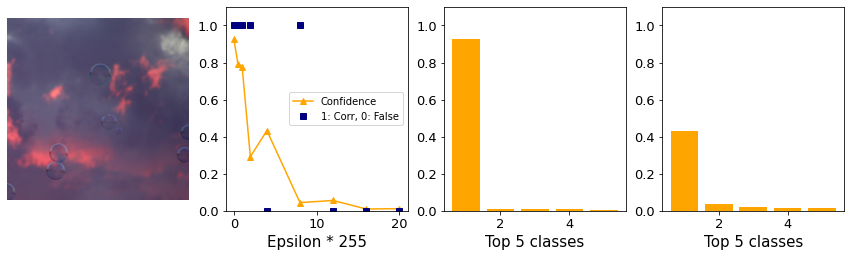

In [14]:
sample = 162

alpha = 1/255
epsilon_conf = 4/255

analyze_attack_ILLM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, fixed_num_iter=None, save_plot=False, print_output=True)

Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.3290288	harvester, reaper
0.5			1			0	0.57468134	school bus
1.0			2			0	0.48547786	school bus
2.0			3			0	0.68898255	school bus
4.0			5			1	0.097493455	harvester, reaper
8.0			10			0	0.018917533	ambulance
12.0			15			0	0.021005802	school bus
16.0			20			0	0.020342937	pillow
20.0			24			0	0.00829571	obelisk


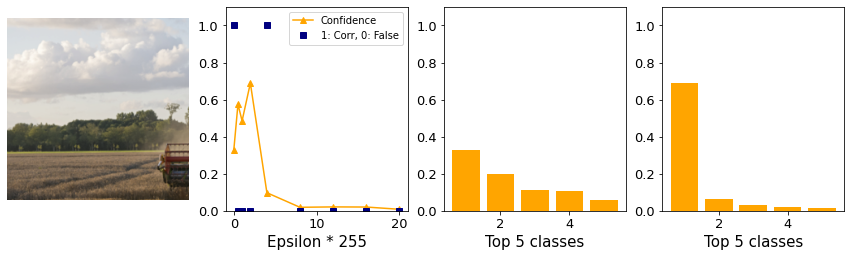

In [15]:
sample = 634

alpha = 1/255
epsilon_conf = 2/255

analyze_attack_ILLM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, fixed_num_iter=None, save_plot=False, print_output=True)

Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.89812696	apron
0.5			1			1	0.51298696	apron
1.0			2			1	0.34635726	apron
2.0			3			1	0.25366345	apron
4.0			5			1	0.34963194	apron
8.0			10			1	0.17873114	apron
12.0			15			1	0.041064613	apron
16.0			20			0	0.02727783	hoopskirt, crinoline
20.0			24			0	0.033000987	hoopskirt, crinoline


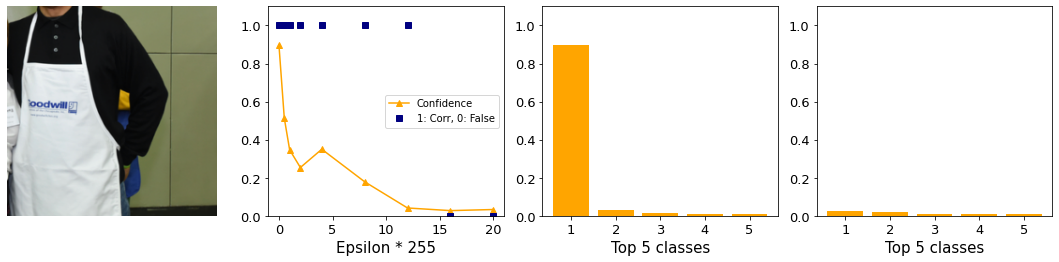

In [7]:
# Example where the targeted class is not that different than the correct one.
sample = 432

alpha = 1/255
epsilon_conf = 16/255

analyze_attack_ILLM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True, print_output=True)

Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.49230596	umbrella
0.5			1			0	0.43483627	lionfish
1.0			2			0	0.22559088	lionfish
2.0			3			0	0.1961492	lionfish
4.0			5			0	0.11074774	lionfish
8.0			10			0	0.020422779	lionfish
12.0			15			0	0.025688646	lionfish
16.0			20			0	0.013119956	jinrikisha, ricksha, rickshaw
20.0			24			0	0.033997916	lionfish


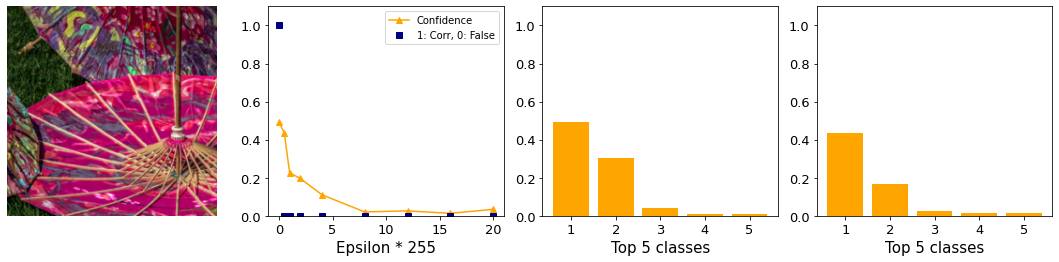

In [8]:
# Example which should be easy to manipulate. Same adver class "lionfish" as with BIM but lower confidence.
# One other class which subjectively is very different from umbrella.
sample = 258

alpha = 1/255
epsilon_conf = 0.5/255

analyze_attack_ILLM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=True, print_output=True)

### Perceptability

We compare adversaries with similar confidence generated by FGSM, BIM and ILLM.

Steps:

1. With FGSM, find the epsilon for which a false class is predicted at the highest confidence.

2. BIM: Find a false class which is predicted at simialr confidence as 1.

3. ILLM: Same as 2nd

In [ ]:
## Good examples:
# Sample 894 fly 90% -> Bow 100% (BIM)
# 

In [74]:
sample = np.random.randint(1, 1000)
print("Sample: " +str(sample) )

Sample: 106


Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9734914	bubble
0.1			1	0.7094946	bubble
0.2			1	0.23090035	bubble
0.3			1	0.059228424	bubble
0.4			0	0.0382526	swing
0.5			0	0.042529944	shopping cart
0.7			0	0.049908306	shopping cart
1.0			0	0.06709202	crib, cot
2.0			0	0.13641463	shopping cart
3.0			0	0.1812582	shopping cart
4.0			0	0.18401988	shopping cart
5.0			0	0.19699137	shopping cart
6.0			0	0.19949552	shopping cart
8.0			0	0.20155184	cradle
10.0			0	0.2171481	cradle
12.0			0	0.2174573	cradle
14.0			0	0.20956318	cradle
16.0			0	0.18705879	cradle
18.0			0	0.19693238	shopping cart
20.0			0	0.23968078	shopping cart


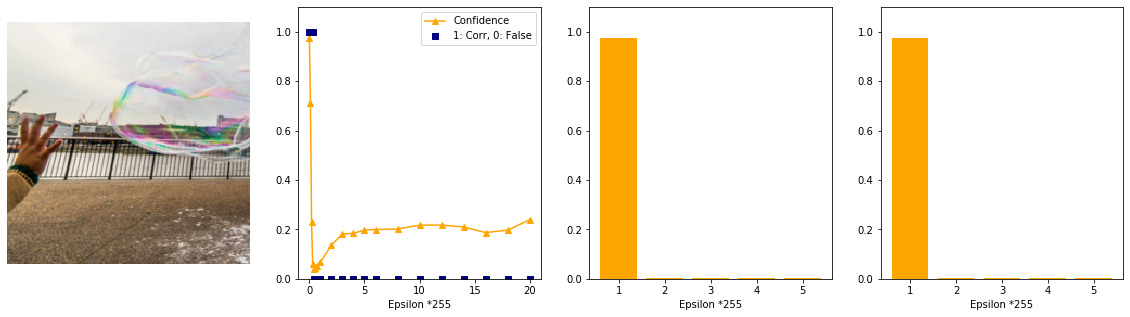

In [75]:
# FGSM
sample = sample
epsilon_conf = 0/255

analyze_attack_FGSM(data_loader, mean, std, model, predict, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.9734914	bubble
0.5			1			0	0.042529795	shopping cart
1.0			2			0	0.09211087	shopping cart
2.0			3			0	0.13897769	crib, cot
4.0			5			0	0.24428476	studio couch, day bed
8.0			10			0	0.24105941	studio couch, day bed
12.0			15			0	0.5886475	studio couch, day bed
16.0			20			0	0.21256226	broom
20.0			24			0	0.20142303	rocking chair, rocker


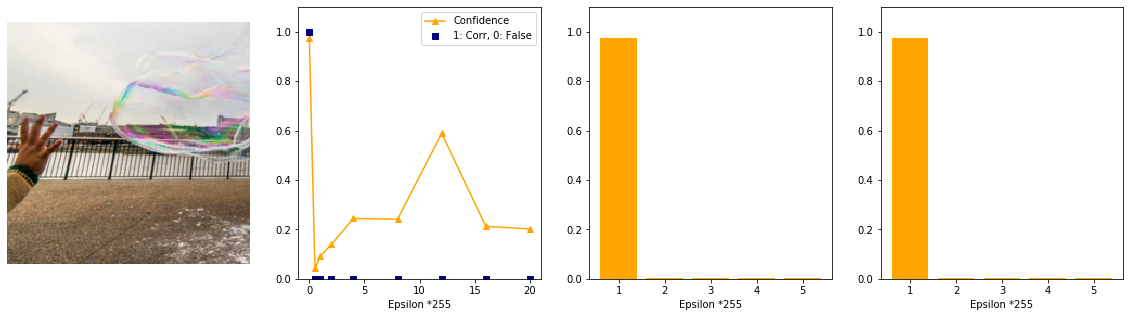

In [76]:
# BIM
alpha = 1/255


analyze_attack_BIM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

Epsilon 	 Iterations 	 Accuracy 	 Confidence 	 Label
0			0			1	0.9734914	bubble
0.5			1			1	0.9287631	bubble
1.0			2			1	0.5474321	bubble
2.0			3			1	0.112778485	bubble
4.0			5			0	0.024391077	mousetrap
8.0			10			0	0.021896789	greenhouse, nursery, glasshouse
12.0			15			0	0.030887507	patio, terrace
16.0			20			0	0.021713942	greenhouse, nursery, glasshouse
20.0			24			0	0.011559745	patio, terrace


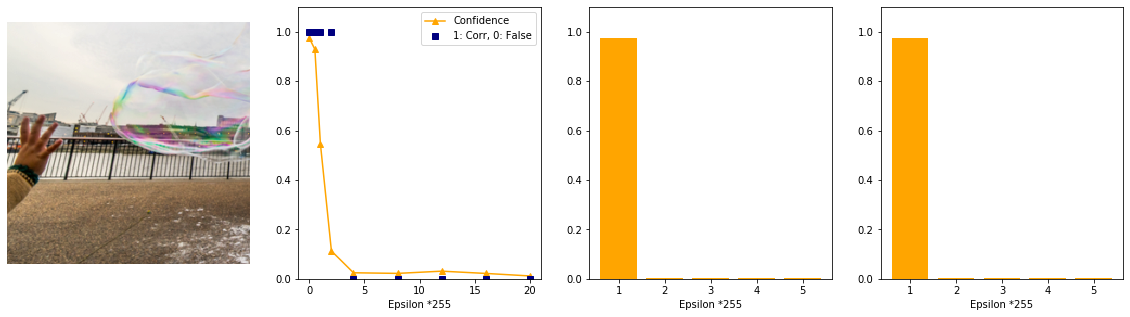

In [77]:
# ILLM

analyze_attack_ILLM(data_loader, mean, std, model, predict, alpha, sample, epsilon_conf, 
                    show_tensor_image, idx_to_name, save_plot=False)

In [78]:
# First plot: original image
#Sample 106
# FGSM: epsilon=20
# -> BIM: epsilon=4
# -> ILLM: epsilon=12 -> (similar confidence not possible since too small. Pick best available) 

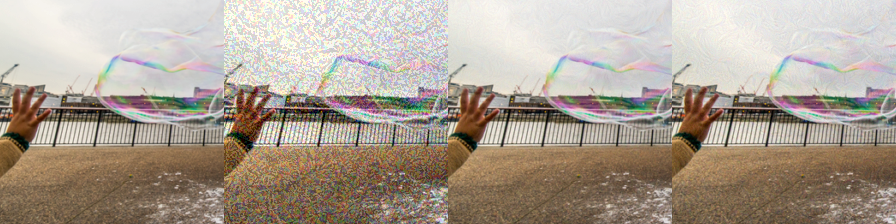

In [8]:
# Get data
sample = 106
eps_fgsm = 20/255
eps_bim = 4/255
eps_illm = 20/255 # 20/255
alpha = 1/255


image_clean, class_index = data_loader.dataset[sample]
image_clean.unsqueeze_(0)
class_index.unsqueeze_(0)

# Predict clean example
_, _, gradient = predict(model, image_clean, class_index, return_grad=True)
  
    
## FGSM
image_fgsm = attack_FGSM(mean, std, image_clean, eps_fgsm, gradient)

## BIM
image_bim = attack_BIM(mean, std, model, image_clean, class_index, eps_bim, alpha, num_iterations=5)

## ILLM
image_illm = attack_ILLM(mean, std, model, image_clean, class_index, eps_illm, alpha, num_iterations=15)


## Convert tensors to images
image_clean = show_tensor_image(image_clean)
image_fgsm = show_tensor_image(image_fgsm)
image_bim = show_tensor_image(image_bim)
image_illm = show_tensor_image(image_illm)

# Put images side-by-side
images = [image_clean, image_fgsm, image_bim, image_illm]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)
output = Image.new('RGB', (total_width, max_height))
x_offset = 0
    
for im in images:
    output.paste(im, (x_offset,0))
    x_offset += im.size[0]
    
output

In [9]:
#output.save("plots/ILLM/ILLM-comparison_all_methods.png")

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*